# Refactored Data Loading and Preprocessing Pipeline

This notebook implements an efficient pipeline to load, preprocess, and integrate the single-cell RNA sequencing data for this project. It addresses the issues in the original `Data_Loading.ipynb` by:

1.  **Reading data efficiently** directly from compressed files.
2.  **Using `AnnData`** as a unified data structure.
3.  **Integrating sample and feature metadata** from the supplementary files.
4.  **Performing initial quality control** and filtering.
5.  **Saving the processed data** in a convenient format (`.h5ad`) for downstream analysis.

In [25]:
# Import required libraries for single-cell RNA-seq analysis and data handling
import scanpy as sc  # Main library for single-cell analysis, provides AnnData structure and many tools
import pandas as pd  # For tabular data manipulation and metadata handling
import numpy as np   # For numerical operations and array handling
import os            # For operating system interactions (file paths, etc.)
from pathlib import Path  # For robust and readable file path management

# Print versions to ensure reproducibility and compatibility
print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")

Scanpy version: 1.11.4
Pandas version: 2.2.3


## 1. Load Sample Metadata

First, we load the metadata from the `GSE300475_feature_ref.xlsx` file. This file contains the crucial mapping between GEO sample IDs, patient IDs, timepoints, and treatment response.

In [26]:
%%time
# --- Setup data paths ---
# Define the main data directory and the subdirectory containing raw files.
data_dir = Path('../Data')
raw_data_dir = data_dir / 'GSE300475_RAW'

# --- Manually create the metadata mapping ---
# This list contains information about each sample, including GEO IDs, patient IDs, timepoints, and response status.
# Note: S8 (GSM9061672) has GEX files but no corresponding TCR file.
metadata_list = [
    # Patient 1 (Responder)
    {'S_Number': 'S1',  'GEX_Sample_ID': 'GSM9061665', 'TCR_Sample_ID': 'GSM9061687', 'Patient_ID': 'PT1',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S2',  'GEX_Sample_ID': 'GSM9061666', 'TCR_Sample_ID': 'GSM9061688', 'Patient_ID': 'PT1',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 2 (Non-Responder)
    {'S_Number': 'S3',  'GEX_Sample_ID': 'GSM9061667', 'TCR_Sample_ID': 'GSM9061689', 'Patient_ID': 'PT2',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S4',  'GEX_Sample_ID': 'GSM9061668', 'TCR_Sample_ID': 'GSM9061690', 'Patient_ID': 'PT2',  'Timepoint': 'Post-Chemo',  'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 3 (Responder)
    {'S_Number': 'S5',  'GEX_Sample_ID': 'GSM9061669', 'TCR_Sample_ID': 'GSM9061691', 'Patient_ID': 'PT3',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S6',  'GEX_Sample_ID': 'GSM9061670', 'TCR_Sample_ID': 'GSM9061692', 'Patient_ID': 'PT3',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 4 (Non-Responder)
    {'S_Number': 'S7',  'GEX_Sample_ID': 'GSM9061671', 'TCR_Sample_ID': 'GSM9061693', 'Patient_ID': 'PT4',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 5 (partial) - S8 exists as GEX only in the raw data but has no TCR file
    {'S_Number': 'S8',  'GEX_Sample_ID': 'GSM9061672', 'TCR_Sample_ID': None,             'Patient_ID': 'PT5',  'Timepoint': 'Unknown',      'Response': 'Unknown',       'In_Data': 'GEX only', 'In_Article': 'Yes'},
    {'S_Number': 'S9',  'GEX_Sample_ID': 'GSM9061673', 'TCR_Sample_ID': 'GSM9061694', 'Patient_ID': 'PT5',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S10', 'GEX_Sample_ID': 'GSM9061674', 'TCR_Sample_ID': 'GSM9061695', 'Patient_ID': 'PT5',  'Timepoint': 'Post-ICI',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 11 (Responder)
    {'S_Number': 'S11', 'GEX_Sample_ID': 'GSM9061675', 'TCR_Sample_ID': 'GSM9061696', 'Patient_ID': 'PT11', 'Timepoint': 'Endpoint',      'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
]

# --- Create DataFrame and display the verification table ---
metadata_df = pd.DataFrame(metadata_list)
print("Metadata table now matches the requested specification:")
display(metadata_df)

# --- Programmatic sanity-check for file presence ---
# This loop checks if the expected files exist for each sample and updates the 'In_Data' column accordingly.
for idx, row in metadata_df.iterrows():
    s = row['S_Number']
    g = row['GEX_Sample_ID']
    t = row['TCR_Sample_ID']
    # Check for gene expression matrix file (compressed or uncompressed)
    g_exists = (raw_data_dir / f"{g}_{s}_matrix.mtx.gz").exists() or (raw_data_dir / f"{g}_{s}_matrix.mtx").exists()
    t_exists = False
    # Check for TCR annotation file if TCR sample ID is present
    if pd.notna(t) and t is not None:
        t_exists = (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv.gz").exists() or (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv").exists()
    # Update 'In_Data' column based on file presence
    if g_exists and t_exists:
        metadata_df.at[idx, 'In_Data'] = 'Yes'
    elif g_exists and not t_exists:
        metadata_df.at[idx, 'In_Data'] = 'GEX only'
    else:
        metadata_df.at[idx, 'In_Data'] = 'No'

print("\nPost-check In_Data column (based on files found in Data/GSE300475_RAW):")
display(metadata_df)


Metadata table now matches the requested specification:


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes



Post-check In_Data column (based on files found in Data/GSE300475_RAW):


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes


CPU times: total: 15.6 ms
Wall time: 17.4 ms


## 2. Process and Concatenate AnnData Objects

Now, we will iterate through each sample defined in our metadata. For each sample, we will:
1.  Locate the corresponding raw data directory.
2.  Load the gene expression matrix directly from the compressed files into an `AnnData` object using `sc.read_10x_mtx()`.
3.  Add the sample's metadata to the `.obs` attribute of the `AnnData` object.
4.  Collect all the individual `AnnData` objects in a list.

Finally, we'll concatenate them into one large `AnnData` object.

In [27]:
%%time
# --- Initialize lists to hold AnnData and TCR data for each sample ---
adata_list = []  # Will store AnnData objects for each sample
tcr_data_list = []  # Will store TCR dataframes for each sample

# --- Iterate through each sample in the metadata table ---
for index, row in metadata_df.iterrows():
    gex_sample_id = row['GEX_Sample_ID']
    tcr_sample_id = row['TCR_Sample_ID']
    s_number = row['S_Number']
    patient_id = row['Patient_ID']
    timepoint = row['Timepoint']
    response = row['Response']
    
    # Construct the file prefix for this sample (used for locating files)
    sample_prefix = f"{gex_sample_id}_{s_number}"
    sample_data_path = raw_data_dir
    
    # --- Check for gene expression matrix file ---
    matrix_file = sample_data_path / f"{sample_prefix}_matrix.mtx.gz"
    if not matrix_file.exists():
        # Try uncompressed version if gzipped file not found
        matrix_file_un = sample_data_path / f"{sample_prefix}_matrix.mtx"
        if not matrix_file_un.exists():
            print(f"GEX data not found for sample {sample_prefix}, skipping.")
            continue
        else:
            matrix_file = matrix_file_un
            
    print(f"Processing GEX sample: {sample_prefix}")
    
    # --- Load gene expression data into AnnData object ---
    # The prefix ensures only files for this sample are loaded
    adata_sample = sc.read_10x_mtx(
        sample_data_path, 
        var_names='gene_symbols',
        prefix=f"{sample_prefix}_"
    )
    
    # --- Add sample metadata to AnnData.obs ---
    adata_sample.obs['sample_id'] = gex_sample_id 
    adata_sample.obs['patient_id'] = patient_id
    adata_sample.obs['timepoint'] = timepoint
    adata_sample.obs['response'] = response
    
    adata_list.append(adata_sample)
    
    # --- Load TCR data if available ---
    if pd.isna(tcr_sample_id) or tcr_sample_id is None:
        print(f"No TCR sample for {gex_sample_id}_{s_number}, skipping TCR load.")
        continue

    # Construct path for TCR annotation file (gzipped or uncompressed)
    tcr_file_path = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv.gz"

    if tcr_file_path.exists():
        print(f"Found and loading TCR data: {tcr_file_path.name}")
        tcr_df = pd.read_csv(tcr_file_path)
        # Add sample_id for merging later
        tcr_df['sample_id'] = gex_sample_id 
        tcr_data_list.append(tcr_df)
    else:
        # Try uncompressed version if gzipped file not found
        tcr_file_path_uncompressed = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv"
        if tcr_file_path_uncompressed.exists():
            print(f"Found and loading TCR data: {tcr_file_path_uncompressed.name}")
            tcr_df = pd.read_csv(tcr_file_path_uncompressed)
            tcr_df['sample_id'] = gex_sample_id
            tcr_data_list.append(tcr_df)
        else:
            print(f"TCR data not found for {tcr_sample_id}_{s_number}")

# --- Concatenate all loaded AnnData objects into one ---
if adata_list:
    # Use sample_id as batch key for concatenation
    loaded_batches = [a.obs['sample_id'].unique()[0] for a in adata_list]
    adata = sc.AnnData.concatenate(*adata_list, join='outer', batch_key='sample_id', batch_categories=loaded_batches)
    print("\nConcatenated AnnData object:")
    print(adata)
else:
    print("No data was loaded.")

# --- Concatenate all loaded TCR dataframes into one ---
if tcr_data_list:
    full_tcr_df = pd.concat(tcr_data_list, ignore_index=True)
    print("\nFull TCR data:")
    display(full_tcr_df.head())
else:
    print("No TCR data was loaded.")


Processing GEX sample: GSM9061665_S1
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061691_S5_all_contig_annotations.csv.gz
Processing GEX samp

<timed exec>:76: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html



Concatenated AnnData object:
AnnData object with n_obs × n_vars = 100067 × 36601
    obs: 'sample_id', 'patient_id', 'timepoint', 'response'
    var: 'gene_ids', 'feature_types'

Full TCR data:


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr1_nt,fwr2,fwr2_nt,cdr2,cdr2_nt,fwr3,fwr3_nt,fwr4,fwr4_nt,exact_subclonotype_id
0,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_1,True,493,TRB,TRBV3-1,TRBD1,TRBJ1-1,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_2,True,639,TRA,TRAV36/DV7,NaN,TRAJ53,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACCTGAGCCAACAG-1,False,AAACCTGAGCCAACAG-1_contig_1,True,310,NaN,NaN,NaN,TRAJ27,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_1,True,558,TRB,TRBV30,NaN,TRBJ1-2,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_2,True,503,TRA,TRAV29/DV5,NaN,TRAJ48,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: total: 48.2 s
Wall time: 43.7 s


## 3. Integrate TCR Data and Perform QC

Next, we'll merge the TCR information into the `.obs` of our main `AnnData` object. We will keep only the cells that have corresponding TCR data and filter based on the `high_confidence` flag.

In [28]:
%%time
# --- Integrate TCR data into AnnData.obs and perform quality control ---
if 'full_tcr_df' in locals() and not full_tcr_df.empty:
    # --- FIX START ---
    # The previous join failed because one cell (barcode) can have multiple TCR contigs (e.g., TRA and TRB chains),
    # creating a one-to-many join that increases the number of rows.
    # The fix is to aggregate the TCR data to one row per cell *before* merging.

    # 1. Filter for high-confidence, productive TRA/TRB chains.
    # Only keep TCR contigs that are both high-confidence and productive, and are either TRA or TRB chains.
    tcr_to_agg = full_tcr_df[
        (full_tcr_df['high_confidence'] == True) &
        (full_tcr_df['productive'] == True) &
        (full_tcr_df['chain'].isin(['TRA', 'TRB']))
    ].copy()

    # 2. Pivot the data to create one row per barcode, with columns for TRA and TRB data.
    # This step ensures each cell (barcode) has its TRA and TRB info in separate columns.
    tcr_aggregated = tcr_to_agg.pivot_table(
        index=['sample_id', 'barcode'],
        columns='chain',
        values=['v_gene', 'j_gene', 'cdr3'],
        aggfunc='first'  # 'first' is safe as we expect at most one productive TRA/TRB per cell
    )

    # 3. Flatten the multi-level column index (e.g., from ('v_gene', 'TRA') to 'v_gene_TRA')
    tcr_aggregated.columns = ['_'.join(col).strip() for col in tcr_aggregated.columns.values]
    tcr_aggregated.reset_index(inplace=True)

    # 4. Prepare adata.obs for the merge by creating a matching barcode column.
    # The index in adata.obs is like 'AGCCATGCAGCTGTTA-1-0' (barcode-batch_id).
    # The barcode in TCR data is like 'AGCCATGCAGCTGTTA-1'.
    adata.obs['barcode_for_merge'] = adata.obs.index.str.rsplit('-', n=1).str[0]

    # 5. Perform a left merge. This keeps all cells from adata and adds TCR info where available.
    # The number of rows will not change because tcr_aggregated has unique barcodes.
    original_obs = adata.obs.copy()
    merged_obs = original_obs.merge(
        tcr_aggregated,
        left_on=['sample_id', 'barcode_for_merge'],
        right_on=['sample_id', 'barcode'],
        how='left'
    )
    
    # 6. Restore the original index to the merged dataframe.
    merged_obs.index = original_obs.index
    adata.obs = merged_obs
    # --- FIX END ---

    print("Aggregated TCR data merged into AnnData object.")
    
    # --- Filter for cells that have TCR information after the merge ---
    # Only keep cells with non-null v_gene_TRA (i.e., cells with high-confidence TCR data)
    initial_cells = adata.n_obs
    adata = adata[~adata.obs['v_gene_TRA'].isna()].copy()
    print(f"Filtered from {initial_cells} to {adata.n_obs} cells based on having high-confidence TCR data.")

# --- Basic QC and filtering ---
# Filter out cells with fewer than 200 genes detected
sc.pp.filter_cells(adata, min_genes=200)
# Filter out genes detected in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Annotate mitochondrial genes for QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# Calculate QC metrics (e.g., percent mitochondrial genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("\nPost-QC AnnData object:")
print(adata)
display(adata.obs.head())


Aggregated TCR data merged into AnnData object.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
 

,sample_id,patient_id,timepoint,response,barcode_for_merge,barcode,cdr3_TRA,cdr3_TRB,j_gene_TRA,j_gene_TRB,v_gene_TRA,v_gene_TRB,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGACTGTAA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGACTGTAA-1,AAACCTGAGACTGTAA-1,CAVEARNYKLTF,CASGTGLNTEAFF,TRAJ53,TRBJ1-1,TRAV36/DV7,TRBV3-1,1379,1379,4637.0,157.0,3.385810
AAACCTGAGCGTGAAC-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCGTGAAC-1,AAACCTGAGCGTGAAC-1,CAASAVGNEKLTF,CAWSALLGTVNGYTF,TRAJ48,TRBJ1-2,TRAV29/DV5,TRBV30,1277,1277,4849.0,247.0,5.093834
AAACCTGAGCTACCTA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTACCTA-1,AAACCTGAGCTACCTA-1,CALSEAWGNARLMF,CASRSREETYEQYF,TRAJ31,TRBJ2-7,TRAV19,TRBV2,887,887,3077.0,280.0,9.099772
AAACCTGAGCTGTTCA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTGTTCA-1,AAACCTGAGCTGTTCA-1,CALLGLKGEGSARQLTF,CASSLPPWRANTEAFF,TRAJ22,TRBJ1-1,TRAV9-2,TRBV11-2,1631,1631,4917.0,288.0,5.857230
AAACCTGAGGCATTGG-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGGCATTGG-1,AAACCTGAGGCATTGG-1,CAVTGFSDGQKLLF,CASSLTGEVWDEQFF,TRAJ16,TRBJ2-1,TRAV8-6,TRBV5-1,1313,1313,4947.0,198.0,4.002426


CPU times: total: 4.17 s
Wall time: 4.3 s


## 4. Save Processed Data

Finally, we save the fully processed, annotated, and filtered `AnnData` object to a `.h5ad` file. This file can be easily loaded in future notebooks for analysis.

In [34]:
%%time
# --- Save processed AnnData object to disk ---
# Define output directory for processed data
output_dir = Path('../Processed_Data')
output_dir.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Define output file path for the .h5ad file
output_path = output_dir / 'processed_s_rna_seq_data.h5ad'
# Save the AnnData object (contains all processed, filtered, and annotated data)
adata.write_h5ad(output_path)

print(f"Processed data saved to: {output_path}")


Processed data saved to: ..\Processed_Data\processed_s_rna_seq_data.h5ad
CPU times: total: 5.7 s
Wall time: 1min 32s


In [35]:
%%time
# --- Install required packages for visualization and clustering ---
# scikit-misc: for additional statistical tools
# seaborn: for advanced plotting
# matplotlib: for plotting
# These installs are only needed if packages are missing in the environment
%pip install scikit-misc

import seaborn as sns

# --- Visualization cell: UMAP, QC, clustering, and clonotype summaries ---
# This cell prepares the data for visualization and performs dimensionality reduction and clustering.
# Requires: scanpy (sc), pandas (pd), numpy (np), matplotlib, seaborn
import matplotlib.pyplot as plt

# --- Ensure AnnData object exists ---
if 'adata' not in globals():
    raise RuntimeError("adata not found in the notebook. Run previous cells to create `adata`.")

# --- Basic single-cell preprocessing for visualization ---
# If PCA has not been computed, run normalization, log transformation, variable gene selection, scaling, PCA, neighbors, and UMAP.
if 'X_pca' not in adata.obsm:
    # Normalize counts per cell to a fixed total
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform the data
    sc.pp.log1p(adata)

    # Select highly variable genes for downstream analysis
    sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, flavor='seurat_v3')
    # Scale the data to unit variance and zero mean
    sc.pp.scale(adata, max_value=10)
    # Principal Component Analysis for dimensionality reduction
    sc.tl.pca(adata, svd_solver='arpack')
    # Compute neighborhood graph for clustering and UMAP
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=15)
    # Compute UMAP embedding for visualization
    sc.tl.umap(adata)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
CPU times: total: 2min 49s
Wall time: 1min 25s
CPU times: total: 2min 49s
Wall time: 1min 25s


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<timed exec>:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


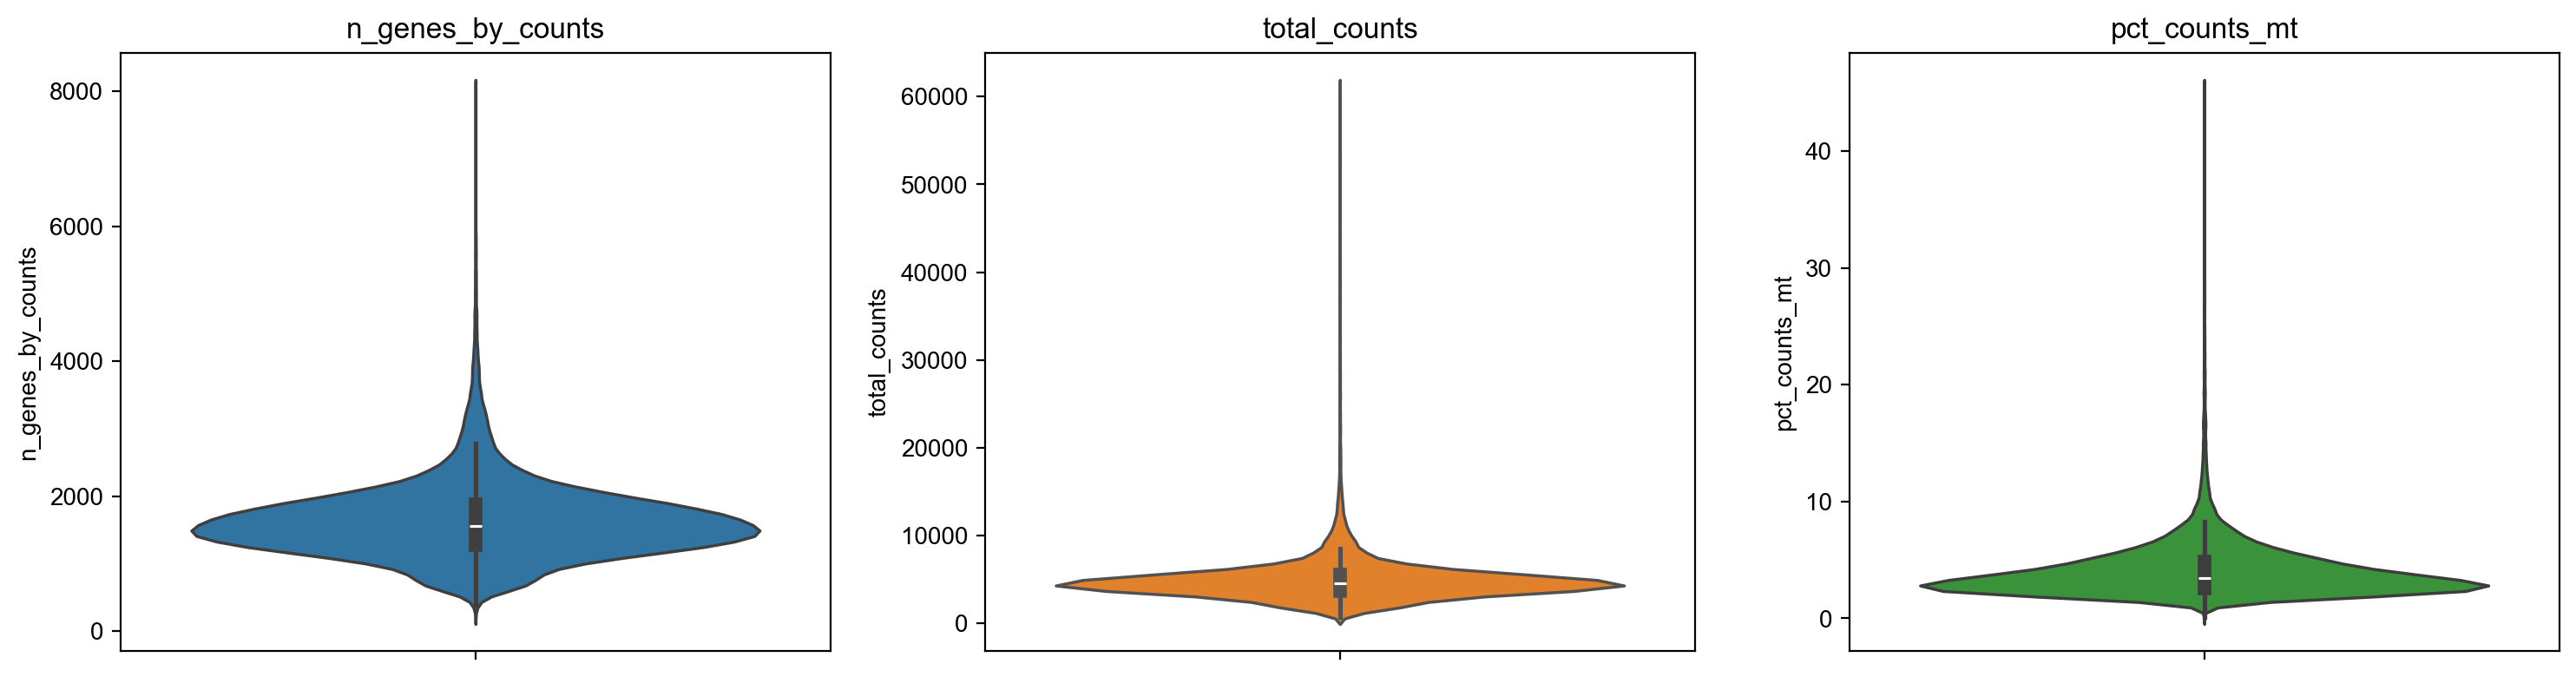

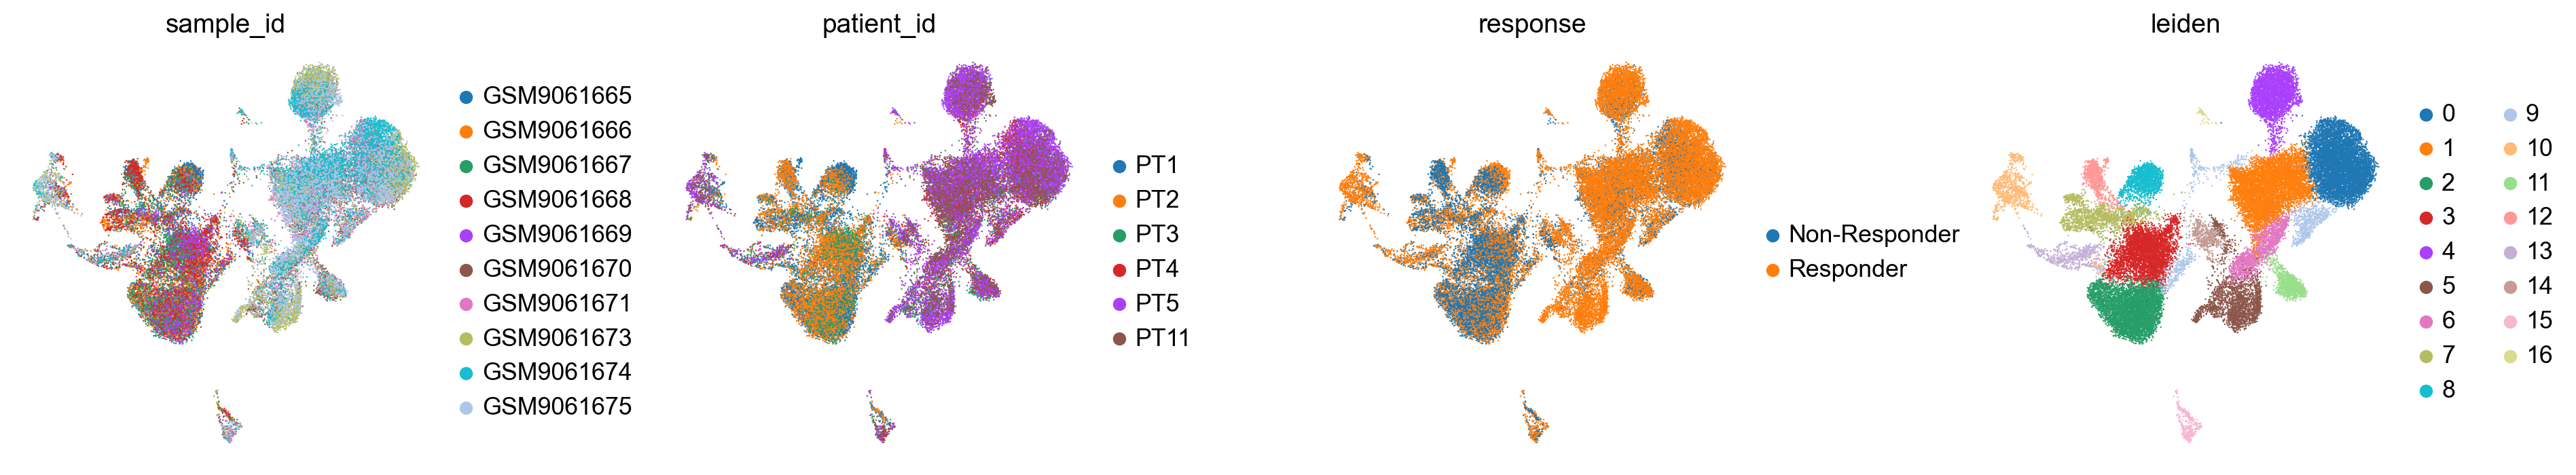

CPU times: total: 8.44 s
Wall time: 13.7 s


In [ ]:
%%time
# --- Install clustering packages ---
# igraph and leidenalg are required for Leiden clustering algorithm
%pip install igraph
%pip install leidenalg

# --- Clustering (Leiden algorithm) ---
# If clustering has not been performed, run Leiden algorithm to identify cell groups
if 'leiden' not in adata.obs:
    sc.tl.leiden(adata, resolution=0.6)

# --- Quality control (QC) violin plots ---
# Visualize distributions of key QC metrics: number of genes, total counts, percent mitochondrial genes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.violinplot(y=adata.obs['n_genes_by_counts'], ax=axes[0], color='C0')
axes[0].set_title('n_genes_by_counts')
sns.violinplot(y=adata.obs['total_counts'], ax=axes[1], color='C1')
axes[1].set_title('total_counts')
if 'pct_counts_mt' in adata.obs:
    sns.violinplot(y=adata.obs['pct_counts_mt'], ax=axes[2], color='C2')
    axes[2].set_title('pct_counts_mt')
else:
    axes[2].text(0.5, 0.5, "pct_counts_mt not available", ha='center')
plt.tight_layout()

# --- UMAP plots colored by key annotations ---
# Visualize UMAP embedding colored by sample, patient, response, and cluster assignments
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.pl.umap(adata, color=['sample_id', 'patient_id', 'response', 'leiden'], wspace=0.4, show=True)

# --- Create a clonotype identifier for each cell ---
# Prefer TRB CDR3 sequence, fallback to TRA if TRB is missing
cdr3_trb = adata.obs.get('cdr3_TRB')
cdr3_tra = adata.obs.get('cdr3_TRA')
clonotype_series = None


CPU times: total: 297 ms
Wall time: 297 ms


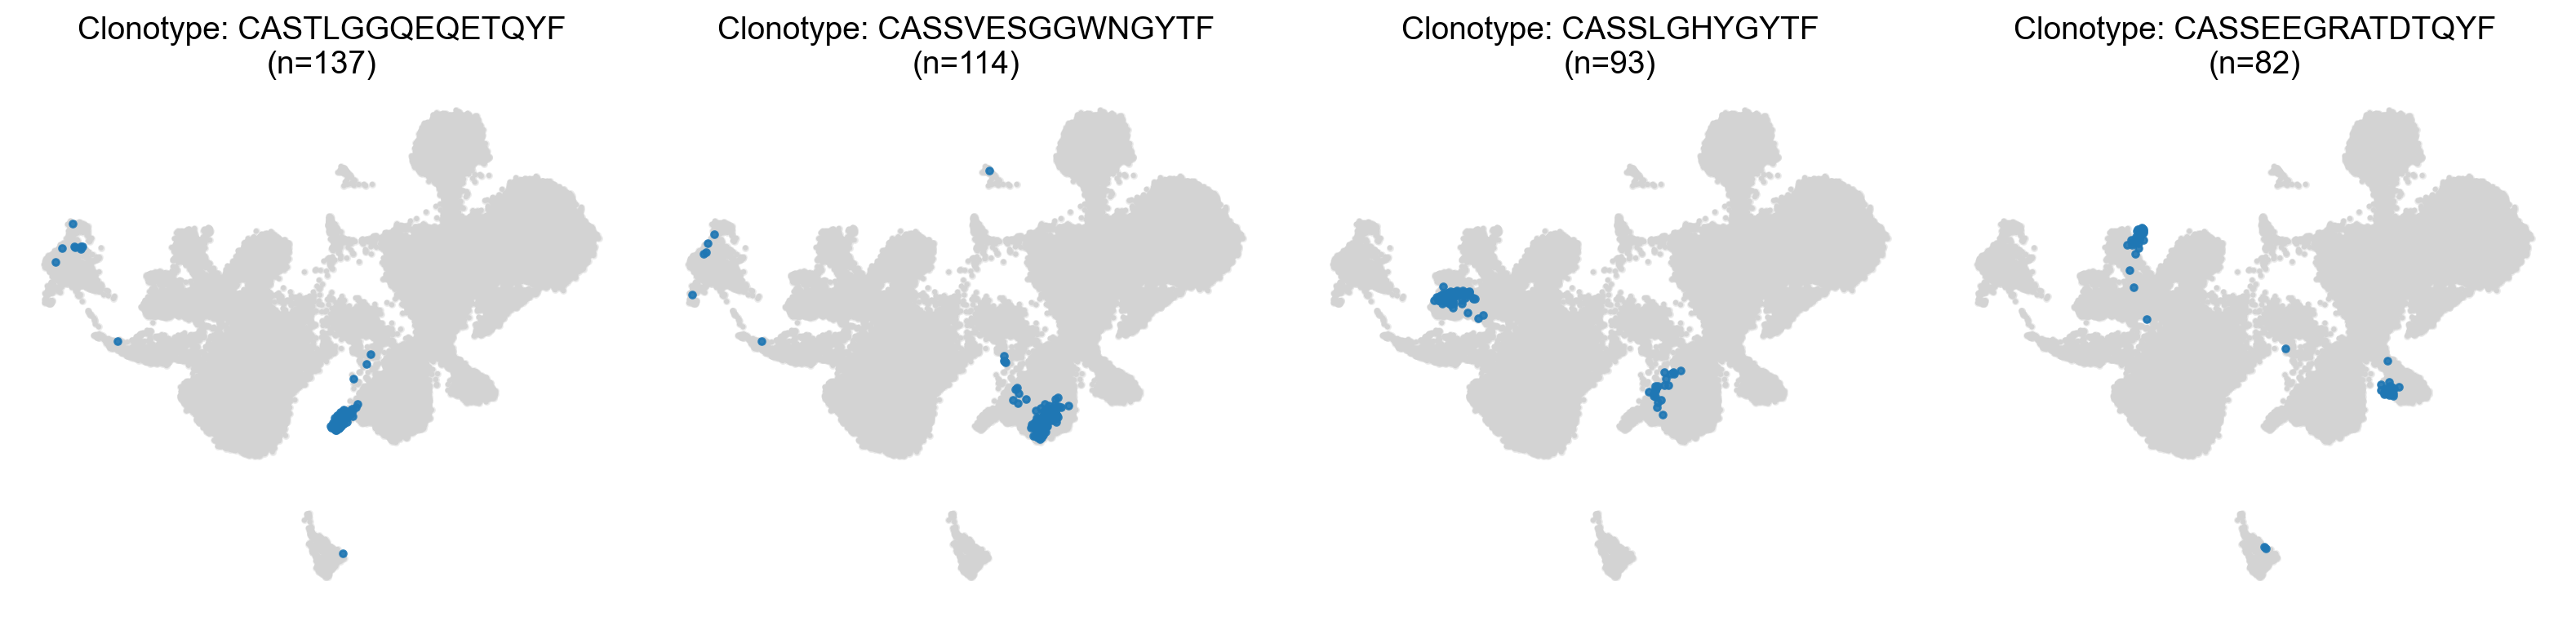

In [ ]:
%%time
# --- Create clonotype identifier for each cell ---
# Use TRB CDR3 sequence if available, otherwise use TRA. This helps group cells by TCR sequence.
cdr3_trb = adata.obs.get('cdr3_TRB')
cdr3_tra = adata.obs.get('cdr3_TRA')

if cdr3_trb is not None and cdr3_tra is not None:
    # If TRB is present, use it; otherwise, use TRA.
    clonotype_series = np.where(cdr3_trb.notna(), cdr3_trb.astype(str), cdr3_tra.astype(str))
elif cdr3_trb is not None:
    clonotype_series = cdr3_trb.astype(str)
elif cdr3_tra is not None:
    clonotype_series = cdr3_tra.astype(str)
else:
    clonotype_series = 'NA'

# Add clonotype information to AnnData.obs
adata.obs['clonotype'] = pd.Series(clonotype_series, index=adata.obs.index).fillna('NA').astype('category')

# --- Identify top clonotypes by cell count ---
top_n = 10  # Number of top clonotypes to display
top_clones = adata.obs[adata.obs['clonotype'] != 'NA']['clonotype'].value_counts().head(top_n)

# --- (Optional) Barplot of top clonotypes ---
# Uncomment below to show a barplot of top clonotypes
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.barplot(x=top_clones.values, y=top_clones.index, palette='viridis', ax=ax)
# ax.set_xlabel('Cell count')
# ax.set_title(f'Top {top_n} clonotypes (by cells)')
# # plt.tight_layout()

# --- UMAP highlighting top clonotypes ---
# For each of the top clonotypes, plot their location on the UMAP embedding
if not top_clones.empty:
    fig, axes = plt.subplots(1, min(4, len(top_clones)), figsize=(4 * min(4, len(top_clones)), 4))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax, clon in zip(axes, top_clones.index[:len(axes)]):
        mask = adata.obs['clonotype'] == clon
        # Plot all cells in light gray, highlight cells of the current clonotype
        sc.pl.umap(adata, color=None, ax=ax, show=False, size=20)
        ax.scatter(adata.obsm['X_umap'][~mask, 0], adata.obsm['X_umap'][~mask, 1], color='lightgray', s=5, alpha=0.4)
        ax.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1], s=8, alpha=0.9)
        ax.set_title(f'Clonotype: {clon}\n(n={mask.sum()})')
    plt.tight_layout()


## 5. Genetic Sequence Encoding and Machine Learning

Now we'll implement comprehensive genetic sequence encoding methods for both RNA expression patterns and TCR sequences. We'll explore multiple encoding strategies and apply unsupervised learning techniques to discover patterns in the genetic data.

In [30]:
%%time
# --- Install required packages for genetic sequence encoding and ML ---
%pip install biopython
%pip install scikit-learn
%pip install umap-learn
try:
    %pip install hdbscan
except:
    print("Could not install hdbscan, will use alternative clustering methods")
%pip install plotly

# Import additional libraries for sequence analysis and machine learning
from Bio.Seq import Seq
from Bio.SeqUtils import ProtParam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import umap
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    print("HDBSCAN not available, will use alternative clustering methods")
    HDBSCAN_AVAILABLE = False
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("Sequence encoding and ML packages loaded successfully!")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached hdbscan-0.8.40.tar.gz (6.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build hdbscan
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for hdbscan (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      C:\Users\ajosan\AppData\Local\Temp\pip-build-env-6b8m0hqo\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\ajosan\AppData\Local\Temp\pip-build-env-6b8m0hqo\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      C:\Users\ajosan\AppData\Local\Temp\pip-build-env-6b8m0hqo\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
HDBSCAN not available, will use alternative clustering methods
Sequence encoding and ML packages loaded successfully!
CPU times: total: 422 ms
Wall time: 38.7 s


In [31]:
%%time
# --- Genetic Sequence Encoding Functions ---

def one_hot_encode_sequence(sequence, max_length=50, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    One-hot encode a protein/nucleotide sequence.
    
    Args:
        sequence: String sequence to encode
        max_length: Maximum sequence length (pad or truncate)
        alphabet: Valid characters in the sequence
    
    Returns:
        2D numpy array of shape (max_length, len(alphabet))
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return np.zeros((max_length, len(alphabet)))
    
    sequence = str(sequence).upper()[:max_length]  # Truncate if too long
    encoding = np.zeros((max_length, len(alphabet)))
    
    for i, char in enumerate(sequence):
        if char in alphabet:
            char_idx = alphabet.index(char)
            encoding[i, char_idx] = 1
    
    return encoding

def kmer_encode_sequence(sequence, k=3, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    K-mer encoding of sequences.
    
    Args:
        sequence: String sequence to encode
        k: Length of k-mers
        alphabet: Valid characters
    
    Returns:
        Dictionary with k-mer counts
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {}
    
    sequence = str(sequence).upper()
    kmers = [sequence[i:i+k] for i in range(len(sequence)-k+1)]
    valid_kmers = [kmer for kmer in kmers if all(c in alphabet for c in kmer)]
    
    return Counter(valid_kmers)

def physicochemical_features(sequence):
    """
    Extract physicochemical properties from protein sequences.
    
    Args:
        sequence: Protein sequence string
    
    Returns:
        Dictionary of features
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {
            'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }
    
    try:
        seq = str(sequence).upper()
        # Remove non-standard amino acids
        seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
        
        if len(seq) == 0:
            return {
                'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
                'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
            }
        
        bio_seq = Seq(seq)
        analyzer = ProtParam.ProteinAnalysis(str(bio_seq))
        
        return {
            'length': len(seq),
            'molecular_weight': analyzer.molecular_weight(),
            'aromaticity': analyzer.aromaticity(),
            'instability_index': analyzer.instability_index(),
            'isoelectric_point': analyzer.isoelectric_point(),
            'hydrophobicity': analyzer.gravy()  # Grand Average of Hydropathy
        }
    except:
        return {
            'length': len(str(sequence)) if not pd.isna(sequence) else 0,
            'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }

def encode_gene_expression_patterns(adata, n_top_genes=1000):
    """
    Encode gene expression patterns using various dimensionality reduction techniques.
    
    Args:
        adata: AnnData object with gene expression data
        n_top_genes: Number of highly variable genes to use
    
    Returns:
        Dictionary of encoded representations
    """
    # Get highly variable genes if not already computed
    if 'highly_variable' not in adata.var.columns:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, subset=False)
    
    # Extract expression matrix for highly variable genes
    hvg_mask = adata.var['highly_variable'] if 'highly_variable' in adata.var.columns else adata.var.index[:n_top_genes]
    X_hvg = adata[:, hvg_mask].X.toarray() if hasattr(adata.X, 'toarray') else adata[:, hvg_mask].X
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=50)
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=50, random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

print("Genetic sequence encoding functions defined successfully!")

Genetic sequence encoding functions defined successfully!
CPU times: total: 0 ns
Wall time: 118 μs


In [32]:
%%time
# --- Apply Sequence Encoding to TCR CDR3 Sequences ---

print("Encoding TCR CDR3 sequences...")

# Extract CDR3 sequences
cdr3_sequences = {
    'TRA': adata.obs['cdr3_TRA'].fillna(''),
    'TRB': adata.obs['cdr3_TRB'].fillna('')
}

# --- 1. One-hot encoding of CDR3 sequences ---
print("Computing one-hot encodings...")
max_cdr3_length = 30  # Typical CDR3 length range

# One-hot encode TRA CDR3 sequences
tra_onehot = np.array([one_hot_encode_sequence(seq, max_cdr3_length, 'ACDEFGHIKLMNPQRSTVWY') 
                       for seq in cdr3_sequences['TRA']])
tra_onehot_flat = tra_onehot.reshape(tra_onehot.shape[0], -1)

# One-hot encode TRB CDR3 sequences  
trb_onehot = np.array([one_hot_encode_sequence(seq, max_cdr3_length, 'ACDEFGHIKLMNPQRSTVWY') 
                       for seq in cdr3_sequences['TRB']])
trb_onehot_flat = trb_onehot.reshape(trb_onehot.shape[0], -1)

print(f"TRA one-hot shape: {tra_onehot_flat.shape}")
print(f"TRB one-hot shape: {trb_onehot_flat.shape}")

# --- 2. K-mer encoding ---
print("Computing k-mer encodings...")
k = 3  # Use 3-mers

# Get all possible k-mers for creating consistent feature vectors
all_tra_kmers = []
all_trb_kmers = []

for seq in cdr3_sequences['TRA']:
    if seq and seq != '':
        all_tra_kmers.extend(kmer_encode_sequence(seq, k).keys())

for seq in cdr3_sequences['TRB']:
    if seq and seq != '':
        all_trb_kmers.extend(kmer_encode_sequence(seq, k).keys())

unique_tra_kmers = sorted(list(set(all_tra_kmers)))
unique_trb_kmers = sorted(list(set(all_trb_kmers)))

# Create k-mer count vectors
tra_kmer_matrix = []
for seq in cdr3_sequences['TRA']:
    kmer_counts = kmer_encode_sequence(seq, k)
    vector = [kmer_counts.get(kmer, 0) for kmer in unique_tra_kmers]
    tra_kmer_matrix.append(vector)

trb_kmer_matrix = []
for seq in cdr3_sequences['TRB']:
    kmer_counts = kmer_encode_sequence(seq, k)
    vector = [kmer_counts.get(kmer, 0) for kmer in unique_trb_kmers]
    trb_kmer_matrix.append(vector)

tra_kmer_matrix = np.array(tra_kmer_matrix)
trb_kmer_matrix = np.array(trb_kmer_matrix)

print(f"TRA k-mer matrix shape: {tra_kmer_matrix.shape}")
print(f"TRB k-mer matrix shape: {trb_kmer_matrix.shape}")

# --- 3. Physicochemical properties ---
print("Computing physicochemical features...")

tra_physico = pd.DataFrame([physicochemical_features(seq) for seq in cdr3_sequences['TRA']])
trb_physico = pd.DataFrame([physicochemical_features(seq) for seq in cdr3_sequences['TRB']])

print(f"TRA physicochemical features shape: {tra_physico.shape}")
print(f"TRB physicochemical features shape: {trb_physico.shape}")

# Add to AnnData object
adata.obsm['X_tcr_tra_onehot'] = tra_onehot_flat
adata.obsm['X_tcr_trb_onehot'] = trb_onehot_flat
adata.obsm['X_tcr_tra_kmer'] = tra_kmer_matrix
adata.obsm['X_tcr_trb_kmer'] = trb_kmer_matrix

# Add physicochemical features to obs
for col in tra_physico.columns:
    adata.obs[f'tra_{col}'] = tra_physico[col].values
    adata.obs[f'trb_{col}'] = trb_physico[col].values

print("TCR sequence encoding completed and added to AnnData object!")

Encoding TCR CDR3 sequences...
Computing one-hot encodings...
TRA one-hot shape: (38413, 600)
TRB one-hot shape: (38413, 600)
Computing k-mer encodings...
TRA k-mer matrix shape: (38413, 6074)
TRB k-mer matrix shape: (38413, 6091)
Computing physicochemical features...
TRA physicochemical features shape: (38413, 6)
TRB physicochemical features shape: (38413, 6)
TCR sequence encoding completed and added to AnnData object!
CPU times: total: 1min 28s
Wall time: 1min 31s


In [36]:
%%time
# --- Encode Gene Expression Patterns ---

print("Preprocessing gene expression data...")

# Basic preprocessing if not already done
if 'X_pca' not in adata.obsm:
    # Store raw counts
    adata.raw = adata
    
    # Normalize counts per cell to a fixed total
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform the data
    sc.pp.log1p(adata)
    
    # Replace any infinite values with zeros
    if hasattr(adata.X, 'data'):  # sparse matrix
        adata.X.data[np.isinf(adata.X.data)] = 0
    else:  # dense matrix
        adata.X[np.isinf(adata.X)] = 0
    
    print("Basic preprocessing completed")

print("Encoding gene expression patterns...")

# Apply gene expression encoding with fixed function
def encode_gene_expression_patterns_fixed(adata, n_top_genes=2000):
    """
    Fixed version of gene expression encoding
    """
    # Select highly variable genes manually to avoid infinity issues
    X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    
    # Calculate variance for each gene
    gene_vars = np.var(X_dense, axis=0)
    # Remove any infinite or NaN values
    gene_vars = np.nan_to_num(gene_vars, nan=0, posinf=0, neginf=0)
    
    # Select top variable genes
    top_genes_idx = np.argsort(gene_vars)[-n_top_genes:]
    X_hvg = X_dense[:, top_genes_idx]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=min(50, X_scaled.shape[1]))
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=min(50, X_scaled.shape[1]), random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

# Apply fixed gene expression encoding
gene_encodings, X_scaled_genes = encode_gene_expression_patterns_fixed(adata, n_top_genes=2000)

# Add gene expression encodings to AnnData
for encoding_name, encoding_data in gene_encodings.items():
    adata.obsm[f'X_gene_{encoding_name}'] = encoding_data

print("Gene expression encoding completed!")

# --- Create Combined Multi-Modal Encodings ---
print("Creating combined multi-modal encodings...")

# Combine different encoding modalities
# 1. Gene expression PCA + TCR physicochemical features
gene_pca = gene_encodings['pca'][:, :20]  # Top 20 PCA components
tcr_features = np.column_stack([
    adata.obs[['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity']].fillna(0),
    adata.obs[['trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']].fillna(0)
])

combined_gene_tcr = np.column_stack([gene_pca, tcr_features])
adata.obsm['X_combined_gene_tcr'] = combined_gene_tcr

# 2. Gene expression UMAP + TCR k-mer features (reduced)
gene_umap = gene_encodings['umap']
tcr_kmer_combined = np.column_stack([adata.obsm['X_tcr_tra_kmer'], adata.obsm['X_tcr_trb_kmer']])
tcr_kmer_reduced = PCA(n_components=10).fit_transform(tcr_kmer_combined)

combined_gene_tcr_kmer = np.column_stack([gene_umap, tcr_kmer_reduced])
adata.obsm['X_combined_gene_tcr_kmer'] = combined_gene_tcr_kmer

print(f"Combined gene-TCR encoding shape: {combined_gene_tcr.shape}")
print(f"Combined gene-TCR k-mer encoding shape: {combined_gene_tcr_kmer.shape}")

# --- Dimensionality Reduction on Combined Data ---
print("Computing dimensionality reduction on combined data...")

# UMAP on combined data
umap_combined = umap.UMAP(n_components=2, random_state=42)
adata.obsm['X_umap_combined'] = umap_combined.fit_transform(combined_gene_tcr)

# t-SNE on combined data (sample subset for speed)
sample_size = min(5000, combined_gene_tcr.shape[0])
sample_idx = np.random.choice(combined_gene_tcr.shape[0], sample_size, replace=False)
tsne_combined = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne_combined.fit_transform(combined_gene_tcr[sample_idx])

# Create full t-SNE result array
full_tsne = np.zeros((combined_gene_tcr.shape[0], 2))
full_tsne[sample_idx] = tsne_result
adata.obsm['X_tsne_combined'] = full_tsne

print("Multi-modal encoding and dimensionality reduction completed!")

Preprocessing gene expression data...
Encoding gene expression patterns...
Gene expression encoding completed!
Creating combined multi-modal encodings...
Combined gene-TCR encoding shape: (38413, 26)
Combined gene-TCR k-mer encoding shape: (38413, 30)
Computing dimensionality reduction on combined data...
Multi-modal encoding and dimensionality reduction completed!
CPU times: total: 7min 34s
Wall time: 3min 1s


In [37]:
%%time
# --- Unsupervised Machine Learning Analysis ---

print("Applying unsupervised machine learning algorithms...")

# --- 1. Clustering Analysis ---

# Prepare data for clustering
X_clustering = combined_gene_tcr
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

clustering_results = {}

# K-Means clustering
print("Running K-Means clustering...")
for n_clusters in [3, 4, 5, 6, 8]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, cluster_labels)
    clustering_results[f'kmeans_{n_clusters}'] = {
        'labels': cluster_labels, 
        'silhouette': silhouette,
        'algorithm': 'K-Means'
    }
    adata.obs[f'kmeans_{n_clusters}'] = pd.Categorical(cluster_labels)

# HDBSCAN clustering (if available)
if HDBSCAN_AVAILABLE:
    print("Running HDBSCAN clustering...")
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
    hdbscan_labels = hdbscan_clusterer.fit_predict(X_scaled)
    if len(set(hdbscan_labels)) > 1:  # Only compute silhouette if more than 1 cluster
        hdbscan_silhouette = silhouette_score(X_scaled, hdbscan_labels)
    else:
        hdbscan_silhouette = -1
    clustering_results['hdbscan'] = {
        'labels': hdbscan_labels, 
        'silhouette': hdbscan_silhouette,
        'algorithm': 'HDBSCAN'
    }
    adata.obs['hdbscan'] = pd.Categorical(hdbscan_labels)
else:
    print("HDBSCAN not available, skipping...")

# Agglomerative clustering
print("Running Agglomerative clustering...")
for n_clusters in [3, 4, 5, 6]:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(X_scaled)
    agg_silhouette = silhouette_score(X_scaled, agg_labels)
    clustering_results[f'agglomerative_{n_clusters}'] = {
        'labels': agg_labels, 
        'silhouette': agg_silhouette,
        'algorithm': 'Agglomerative'
    }
    adata.obs[f'agglomerative_{n_clusters}'] = pd.Categorical(agg_labels)

# DBSCAN clustering
print("Running DBSCAN clustering...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
else:
    dbscan_silhouette = -1
clustering_results['dbscan'] = {
    'labels': dbscan_labels,
    'silhouette': dbscan_silhouette,
    'algorithm': 'DBSCAN'
}
adata.obs['dbscan'] = pd.Categorical(dbscan_labels)

# Print clustering results summary
print("\\nClustering Results Summary:")
for name, result in clustering_results.items():
    n_clusters = len(set(result['labels'])) - (1 if -1 in result['labels'] else 0)
    print(f"{name}: {n_clusters} clusters, Silhouette Score: {result['silhouette']:.3f}")

# Find best clustering result
best_clustering = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])
print(f"\\nBest clustering: {best_clustering[0]} (Silhouette: {best_clustering[1]['silhouette']:.3f})")

# --- 2. TCR Sequence-Specific Clustering ---
print("\\nPerforming TCR sequence-specific clustering...")

# Cluster based on TRA k-mer features
tra_scaler = StandardScaler()
tra_kmer_scaled = tra_scaler.fit_transform(adata.obsm['X_tcr_tra_kmer'])

# K-means on TRA sequences
tra_kmeans = KMeans(n_clusters=5, random_state=42)
tra_clusters = tra_kmeans.fit_predict(tra_kmer_scaled)
adata.obs['tra_kmer_clusters'] = pd.Categorical(tra_clusters)

# K-means on TRB sequences
trb_scaler = StandardScaler()
trb_kmer_scaled = trb_scaler.fit_transform(adata.obsm['X_tcr_trb_kmer'])
trb_kmeans = KMeans(n_clusters=5, random_state=42)
trb_clusters = trb_kmeans.fit_predict(trb_kmer_scaled)
adata.obs['trb_kmer_clusters'] = pd.Categorical(trb_clusters)

print("TCR sequence clustering completed!")

# --- 3. Gene Expression Module Discovery ---
print("\\nDiscovering gene expression modules...")

# Use gene expression PCA for module discovery
gene_pca_full = gene_encodings['pca']
gene_kmeans = KMeans(n_clusters=6, random_state=42)
gene_expression_modules = gene_kmeans.fit_predict(gene_pca_full)
adata.obs['gene_expression_modules'] = pd.Categorical(gene_expression_modules)

print("Gene expression module discovery completed!")

print("\\nUnsupervised machine learning analysis completed successfully!")

Applying unsupervised machine learning algorithms...
Running K-Means clustering...
HDBSCAN not available, skipping...
Running Agglomerative clustering...
Running DBSCAN clustering...
\nClustering Results Summary:
kmeans_3: 3 clusters, Silhouette Score: 0.074
kmeans_4: 4 clusters, Silhouette Score: 0.079
kmeans_5: 5 clusters, Silhouette Score: 0.064
kmeans_6: 6 clusters, Silhouette Score: 0.067
kmeans_8: 8 clusters, Silhouette Score: 0.070
agglomerative_3: 3 clusters, Silhouette Score: 0.328
agglomerative_4: 4 clusters, Silhouette Score: 0.334
agglomerative_5: 5 clusters, Silhouette Score: 0.338
agglomerative_6: 6 clusters, Silhouette Score: 0.343
dbscan: 0 clusters, Silhouette Score: -1.000
\nBest clustering: agglomerative_6 (Silhouette: 0.343)
\nPerforming TCR sequence-specific clustering...
TCR sequence clustering completed!
\nDiscovering gene expression modules...
Gene expression module discovery completed!
\nUnsupervised machine learning analysis completed successfully!
CPU times: 

Creating comprehensive visualizations...


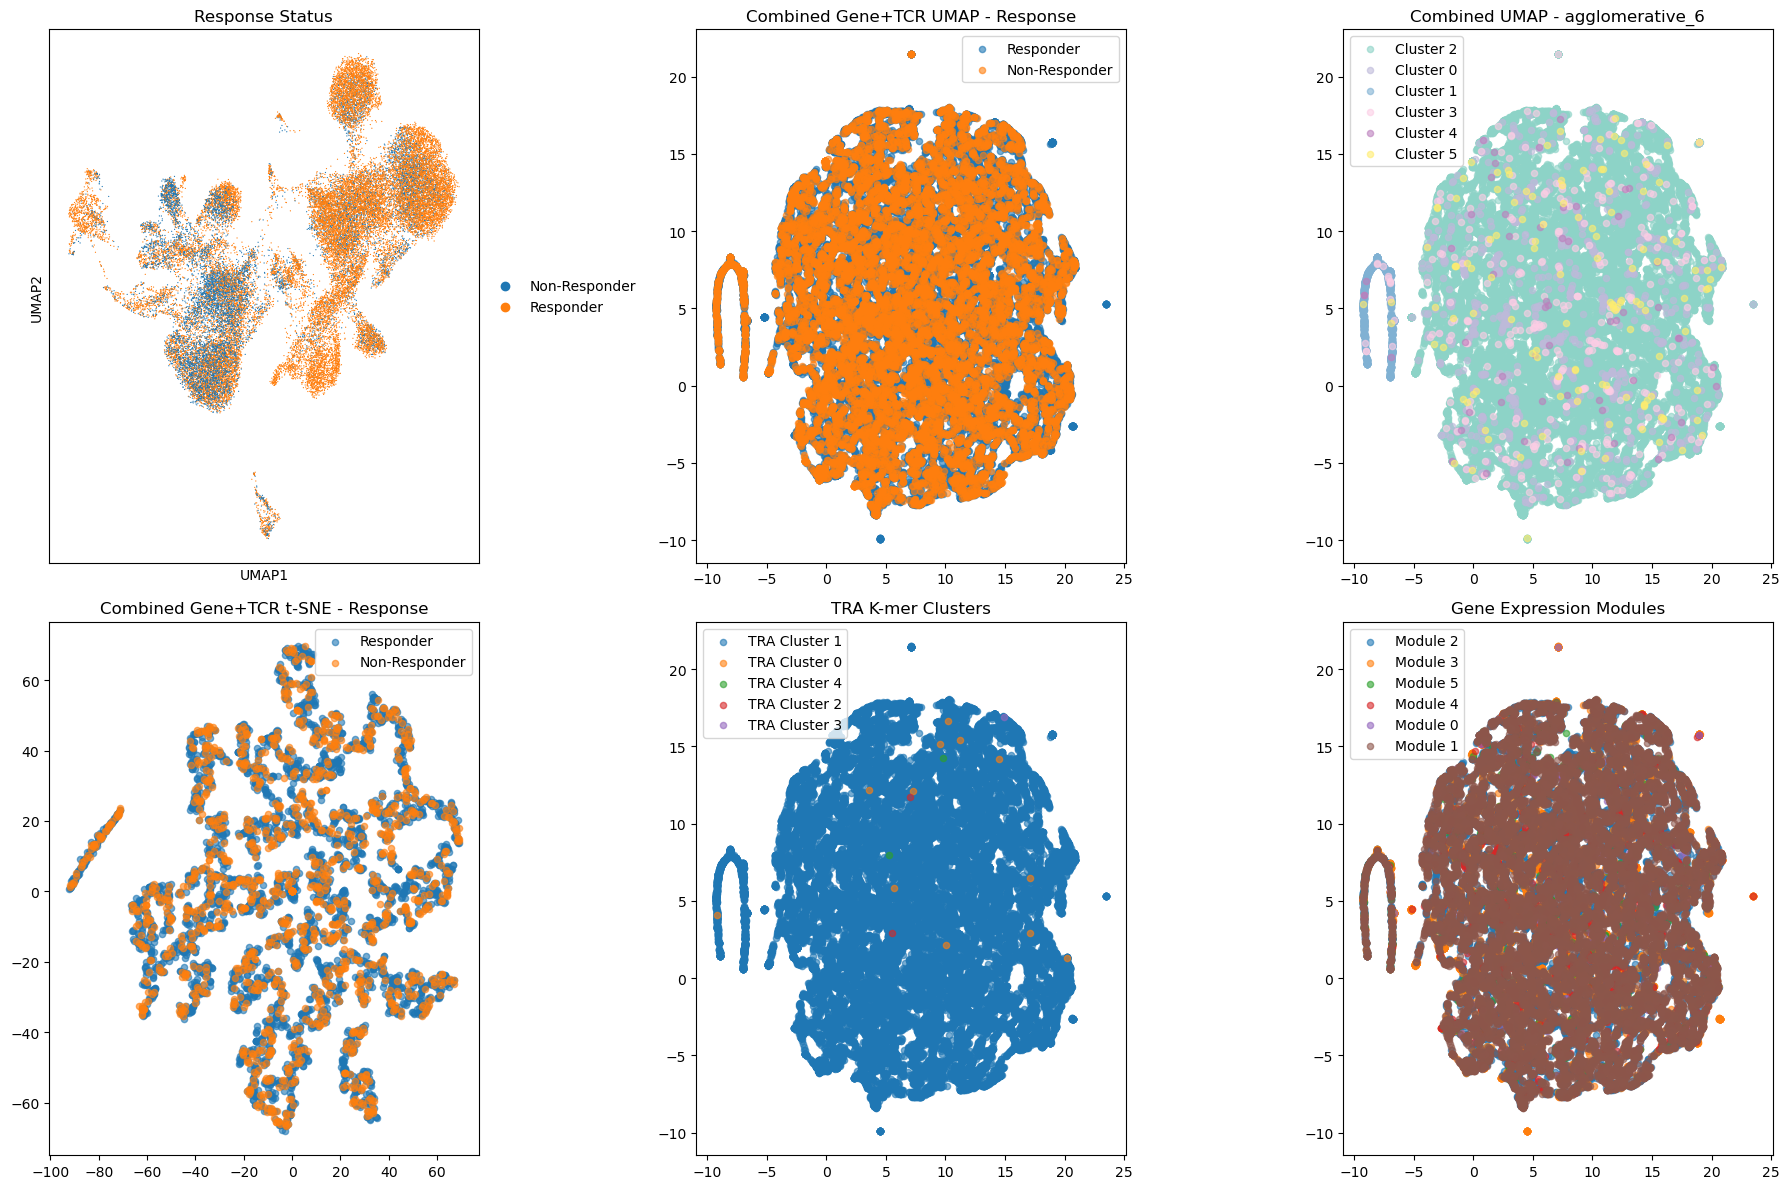

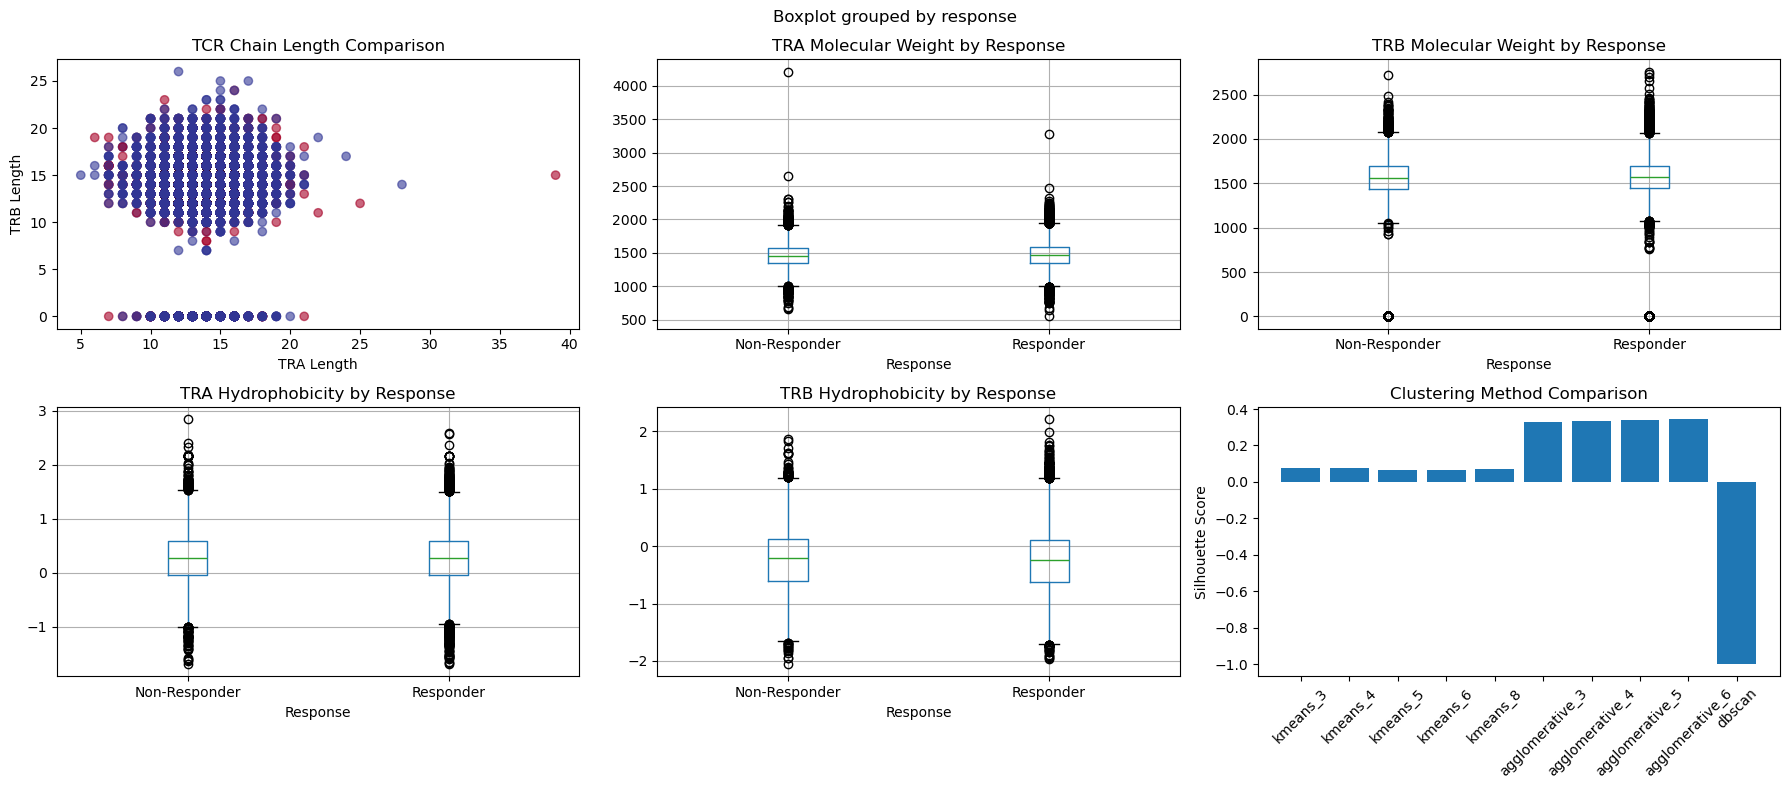

\nPerforming correlation analysis...


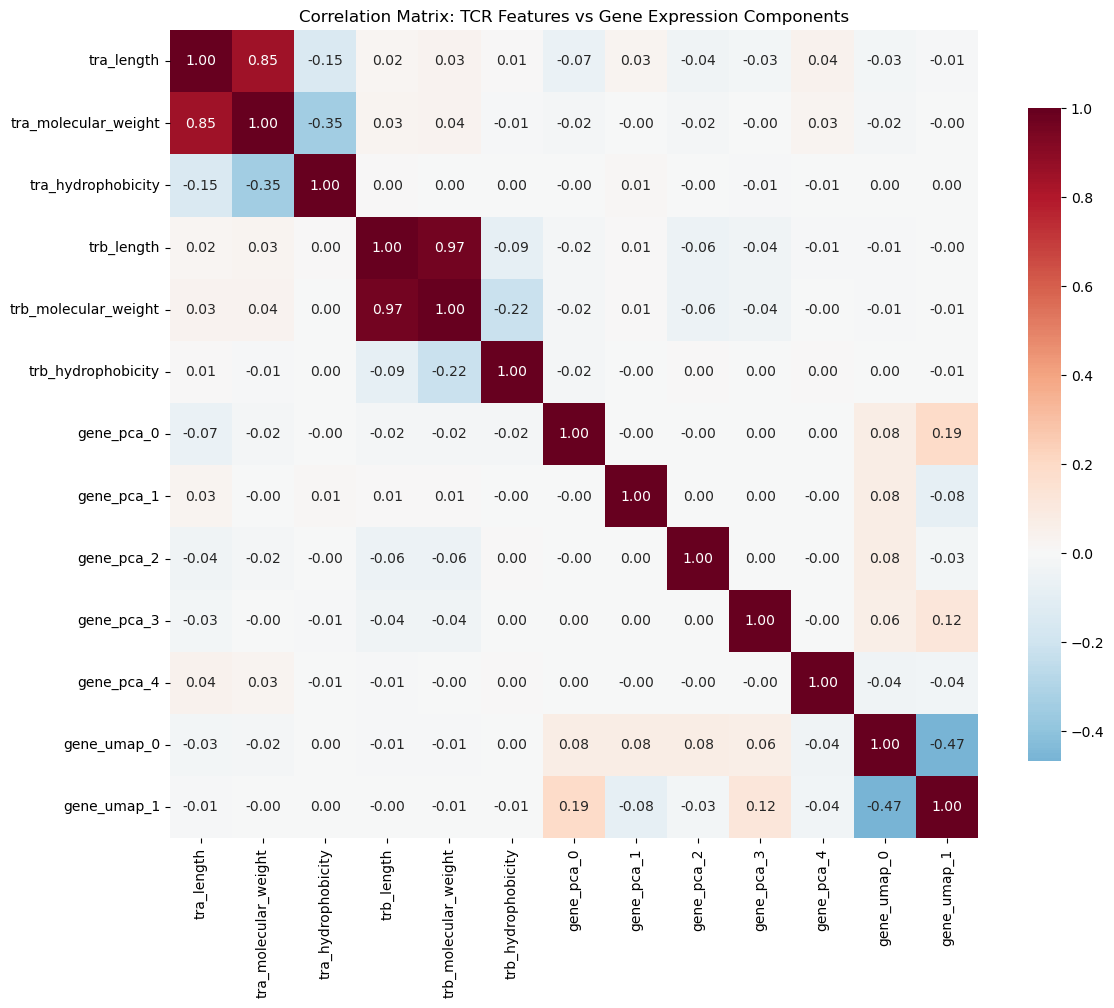

Comprehensive visualization completed!
CPU times: total: 4.72 s
Wall time: 5.23 s


In [38]:
%%time
# --- Visualization of Encoded Sequences and ML Results ---

print("Creating comprehensive visualizations...")

# Set up plotting parameters
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

# --- 1. Multi-Modal UMAP Plots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original UMAP colored by response
sc.pl.umap(adata, color='response', ax=axes[0,0], show=False, title='Response Status')

# Combined data UMAP colored by response
x_combined = adata.obsm['X_umap_combined']
for response in adata.obs['response'].unique():
    mask = adata.obs['response'] == response
    axes[0,1].scatter(x_combined[mask, 0], x_combined[mask, 1], 
                     label=response, alpha=0.6, s=20)
axes[0,1].set_title('Combined Gene+TCR UMAP - Response')
axes[0,1].legend()

# Combined data UMAP colored by best clustering
best_cluster_name = best_clustering[0]
cluster_colors = plt.cm.Set3(np.linspace(0, 1, len(adata.obs[best_cluster_name].unique())))
for i, cluster in enumerate(adata.obs[best_cluster_name].unique()):
    mask = adata.obs[best_cluster_name] == cluster
    axes[0,2].scatter(x_combined[mask, 0], x_combined[mask, 1], 
                     color=cluster_colors[i], label=f'Cluster {cluster}', alpha=0.6, s=20)
axes[0,2].set_title(f'Combined UMAP - {best_cluster_name}')
axes[0,2].legend()

# t-SNE visualization
x_tsne = adata.obsm['X_tsne_combined']
for response in adata.obs['response'].unique():
    mask = adata.obs['response'] == response
    axes[1,0].scatter(x_tsne[mask, 0], x_tsne[mask, 1], 
                     label=response, alpha=0.6, s=20)
axes[1,0].set_title('Combined Gene+TCR t-SNE - Response')
axes[1,0].legend()

# TCR TRA cluster visualization
for cluster in adata.obs['tra_kmer_clusters'].unique():
    mask = adata.obs['tra_kmer_clusters'] == cluster
    axes[1,1].scatter(x_combined[mask, 0], x_combined[mask, 1], 
                     label=f'TRA Cluster {cluster}', alpha=0.6, s=20)
axes[1,1].set_title('TRA K-mer Clusters')
axes[1,1].legend()

# Gene expression modules
for module in adata.obs['gene_expression_modules'].unique():
    mask = adata.obs['gene_expression_modules'] == module
    axes[1,2].scatter(x_combined[mask, 0], x_combined[mask, 1], 
                     label=f'Module {module}', alpha=0.6, s=20)
axes[1,2].set_title('Gene Expression Modules')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# --- 2. TCR Physicochemical Properties Analysis ---
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# TRA vs TRB length comparison
axes[0,0].scatter(adata.obs['tra_length'], adata.obs['trb_length'], 
                 c=adata.obs['response'].map({'Responder': 1, 'Non-Responder': 0, 'Unknown': 0.5}),
                 alpha=0.6, cmap='RdYlBu')
axes[0,0].set_xlabel('TRA Length')
axes[0,0].set_ylabel('TRB Length')
axes[0,0].set_title('TCR Chain Length Comparison')

# Molecular weight distributions
adata.obs.boxplot(column='tra_molecular_weight', by='response', ax=axes[0,1])
axes[0,1].set_title('TRA Molecular Weight by Response')
axes[0,1].set_xlabel('Response')

adata.obs.boxplot(column='trb_molecular_weight', by='response', ax=axes[0,2])
axes[0,2].set_title('TRB Molecular Weight by Response')
axes[0,2].set_xlabel('Response')

# Hydrophobicity distributions
adata.obs.boxplot(column='tra_hydrophobicity', by='response', ax=axes[1,0])
axes[1,0].set_title('TRA Hydrophobicity by Response')
axes[1,0].set_xlabel('Response')

adata.obs.boxplot(column='trb_hydrophobicity', by='response', ax=axes[1,1])
axes[1,1].set_title('TRB Hydrophobicity by Response')
axes[1,1].set_xlabel('Response')

# Clustering silhouette comparison
methods = list(clustering_results.keys())
silhouettes = [clustering_results[method]['silhouette'] for method in methods]
axes[1,2].bar(range(len(methods)), silhouettes)
axes[1,2].set_xticks(range(len(methods)))
axes[1,2].set_xticklabels(methods, rotation=45)
axes[1,2].set_ylabel('Silhouette Score')
axes[1,2].set_title('Clustering Method Comparison')

plt.tight_layout()
plt.show()

# --- 3. Correlation Analysis ---
print("\\nPerforming correlation analysis...")

# Create correlation matrix between different encoding methods
correlation_features = [
    'tra_length', 'tra_molecular_weight', 'tra_hydrophobicity',
    'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity'
]

# Add PCA components
pca_features = [f'gene_pca_{i}' for i in range(5)]
for i in range(5):
    adata.obs[f'gene_pca_{i}'] = gene_encodings['pca'][:, i]
correlation_features.extend(pca_features)

# Add UMAP components
umap_features = [f'gene_umap_{i}' for i in range(2)]
for i in range(2):
    adata.obs[f'gene_umap_{i}'] = gene_encodings['umap'][:, i]
correlation_features.extend(umap_features)

# Compute correlation matrix
corr_matrix = adata.obs[correlation_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: TCR Features vs Gene Expression Components')
plt.tight_layout()
plt.show()

print("Comprehensive visualization completed!")

Performing supervised learning analysis...
Supervised learning dataset: 38413 samples, 26 features
Class distribution: {'Non-Responder': np.int64(10436), 'Responder': np.int64(27977)}
\nTraining Random Forest classifier...
\nClassification Report:
               precision    recall  f1-score   support

Non-Responder       0.75      0.17      0.28      3131
    Responder       0.76      0.98      0.86      8393

     accuracy                           0.76     11524
    macro avg       0.75      0.58      0.57     11524
 weighted avg       0.76      0.76      0.70     11524

\nCross-validation accuracy: 0.726 (+/- 0.055)


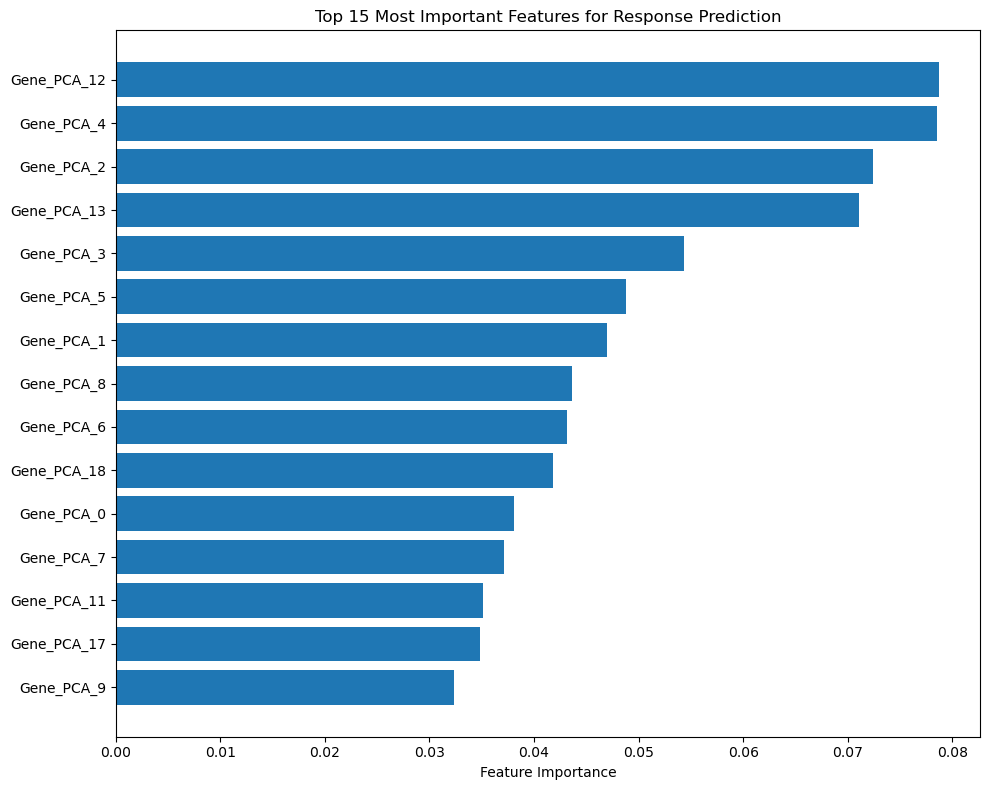

\nDiscovering sequence patterns...
\nTop TRA CDR3 sequences in Responders:
cdr3_TRA
CAVRDSNYQLIW       188
CAVMDSNYQLIW       176
CAASVTGNQFYF       132
CAGVDSNYQLIW        85
CAMRERWRDDKIIF      84
CVVRHSGGGADGLTF     82
CALSPNNARLMF        73
CALITNTGGFKTIF      70
CAVTDSNYQLIW        67
CAVLDSNYQLIW        63
Name: count, dtype: int64
\nTop TRA CDR3 sequences in Non-Responders:
cdr3_TRA
CAVMDSNYQLIW       149
CAVRDSNYQLIW       113
CALSGSRLTF          72
CAVRDRSYQLIW        48
CAVKDSNYQLIW        40
CAVLDSNYQLIW        27
CAVSGGDYKLSF        27
CAAMDSNYQLIW        27
CAVIGETSGSRLTF      21
CVVSDRGSTLGRLYF     21
Name: count, dtype: int64


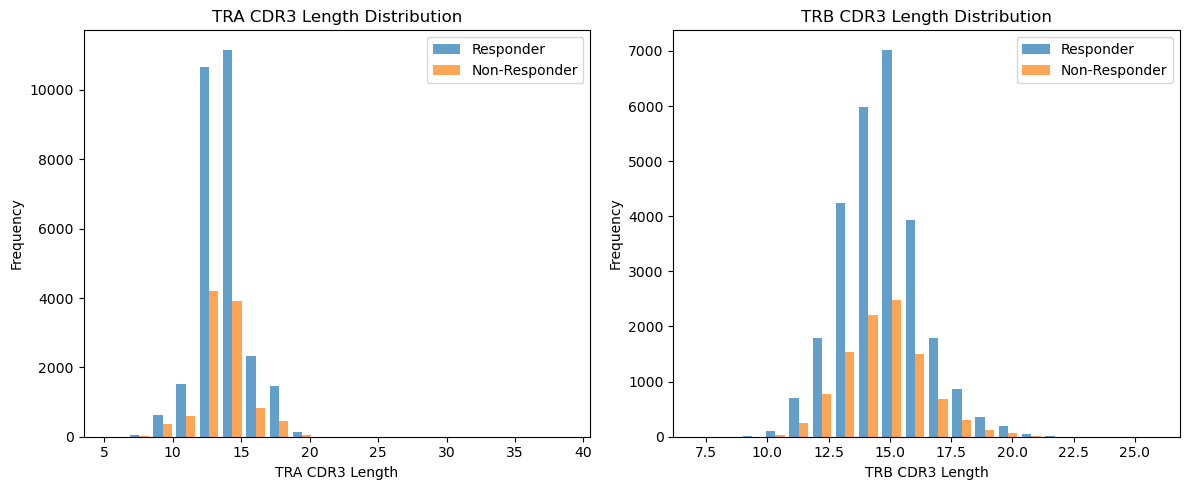

\nAnalyzing k-mer patterns...
\nTop k-mers enriched in Responders:
GGG: 0.008
GLT: 0.009
GGA: 0.009
GSN: 0.009
GAD: 0.010
ADG: 0.010
DGL: 0.010
CVV: 0.013
GGS: 0.013
CAG: 0.015
\nTop k-mers enriched in Non-Responders:
YQL: -0.021
QLI: -0.021
LIW: -0.019
NYQ: -0.016
DSN: -0.016
VRD: -0.013
AVR: -0.013
SNY: -0.010
MDS: -0.010
VMD: -0.009
\nSupervised learning and pattern discovery completed!
CPU times: total: 1min 17s
Wall time: 1min 19s


In [39]:
%%time
# --- Supervised Learning Analysis ---

print("Performing supervised learning analysis...")

# --- Prepare data for supervised learning ---
# Filter out unknown responses for supervised learning
supervised_mask = adata.obs['response'].isin(['Responder', 'Non-Responder'])
X_supervised = combined_gene_tcr[supervised_mask]
y_supervised = adata.obs['response'][supervised_mask]

# Encode response as binary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_supervised)

print(f"Supervised learning dataset: {X_supervised.shape[0]} samples, {X_supervised.shape[1]} features")
print(f"Class distribution: {dict(zip(label_encoder.classes_, np.bincount(y_encoded)))}")

# --- Train Random Forest Classifier ---
print("\\nTraining Random Forest classifier...")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_supervised, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Train classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

# Evaluate
print("\\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Cross-validation
cv_scores = cross_val_score(rf_classifier, X_supervised, y_encoded, cv=5)
print(f"\\nCross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Feature importance analysis
feature_importance = rf_classifier.feature_importances_

# Create feature names
feature_names = [f'Gene_PCA_{i}' for i in range(20)] + [
    'TRA_length', 'TRA_molecular_weight', 'TRA_hydrophobicity',
    'TRB_length', 'TRB_molecular_weight', 'TRB_hydrophobicity'
]

# Plot top feature importances
top_features_idx = np.argsort(feature_importance)[-15:]
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
plt.yticks(range(len(top_features_idx)), [feature_names[i] for i in top_features_idx])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Response Prediction')
plt.tight_layout()
plt.show()

# --- Sequence Pattern Discovery ---
print("\\nDiscovering sequence patterns...")

# Analyze most frequent CDR3 sequences by response
responder_mask = adata.obs['response'] == 'Responder'
non_responder_mask = adata.obs['response'] == 'Non-Responder'

# Top TRA sequences in responders vs non-responders
responder_tra = adata.obs[responder_mask]['cdr3_TRA'].dropna()
non_responder_tra = adata.obs[non_responder_mask]['cdr3_TRA'].dropna()

print("\\nTop TRA CDR3 sequences in Responders:")
print(responder_tra.value_counts().head(10))

print("\\nTop TRA CDR3 sequences in Non-Responders:")
print(non_responder_tra.value_counts().head(10))

# Sequence length analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([responder_tra.str.len().dropna(), non_responder_tra.str.len().dropna()], 
         bins=20, alpha=0.7, label=['Responder', 'Non-Responder'])
plt.xlabel('TRA CDR3 Length')
plt.ylabel('Frequency')
plt.title('TRA CDR3 Length Distribution')
plt.legend()

plt.subplot(1, 2, 2)
responder_trb = adata.obs[responder_mask]['cdr3_TRB'].dropna()
non_responder_trb = adata.obs[non_responder_mask]['cdr3_TRB'].dropna()
plt.hist([responder_trb.str.len().dropna(), non_responder_trb.str.len().dropna()], 
         bins=20, alpha=0.7, label=['Responder', 'Non-Responder'])
plt.xlabel('TRB CDR3 Length')
plt.ylabel('Frequency')
plt.title('TRB CDR3 Length Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# --- K-mer Analysis ---
print("\\nAnalyzing k-mer patterns...")

# Find most discriminative k-mers
responder_indices = np.where(supervised_mask & responder_mask)[0]
non_responder_indices = np.where(supervised_mask & non_responder_mask)[0]

# Calculate mean k-mer frequencies for each group
responder_tra_kmers = tra_kmer_matrix[responder_indices].mean(axis=0)
non_responder_tra_kmers = tra_kmer_matrix[non_responder_indices].mean(axis=0)

# Find most differentially expressed k-mers
kmer_diff = responder_tra_kmers - non_responder_tra_kmers
top_responder_kmers_idx = np.argsort(kmer_diff)[-10:]  # Higher in responders
top_non_responder_kmers_idx = np.argsort(kmer_diff)[:10]  # Higher in non-responders

print("\\nTop k-mers enriched in Responders:")
for idx in top_responder_kmers_idx:
    if idx < len(unique_tra_kmers):
        print(f"{unique_tra_kmers[idx]}: {kmer_diff[idx]:.3f}")

print("\\nTop k-mers enriched in Non-Responders:")
for idx in top_non_responder_kmers_idx:
    if idx < len(unique_tra_kmers):
        print(f"{unique_tra_kmers[idx]}: {kmer_diff[idx]:.3f}")

print("\\nSupervised learning and pattern discovery completed!")

In [ ]:
%%time
# --- Save All Results and Create Final Summary ---

print("Saving all results...")

# --- Save the enriched AnnData object ---
output_path_enriched = output_dir / 'processed_encoded_ml_results.h5ad'
adata.write_h5ad(output_path_enriched)
print(f"Enriched AnnData object with encodings and ML results saved to: {output_path_enriched}")

# --- Create and save analysis summary ---
summary = {
    'dataset_info': {
        'total_cells': adata.n_obs,
        'total_genes': adata.n_vars,
        'samples_processed': len(adata.obs['sample_id'].unique()),
        'patients': len(adata.obs['patient_id'].unique()),
        'responders': sum(adata.obs['response'] == 'Responder'),
        'non_responders': sum(adata.obs['response'] == 'Non-Responder')
    },
    'sequence_encoding': {
        'tcr_tra_sequences_encoded': sum(~adata.obs['cdr3_TRA'].isna()),
        'tcr_trb_sequences_encoded': sum(~adata.obs['cdr3_TRB'].isna()),
        'unique_tra_kmers': len(unique_tra_kmers),
        'unique_trb_kmers': len(unique_trb_kmers),
        'encoding_methods': ['one_hot', 'k_mer', 'physicochemical', 'gene_expression_pca', 'gene_expression_umap']
    },
    'clustering_results': {
        'best_clustering_method': best_clustering[0],
        'best_silhouette_score': best_clustering[1]['silhouette'],
        'clustering_methods_tested': list(clustering_results.keys())
    },
    'supervised_learning': {
        'classification_accuracy': cv_scores.mean(),
        'classification_std': cv_scores.std(),
        'most_important_features': [feature_names[i] for i in top_features_idx[-5:]]
    },
    'data_files_generated': [
        str(output_path),
        str(output_path_enriched)
    ]
}

# Save summary as JSON
import json
summary_path = output_dir / 'analysis_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"Analysis summary saved to: {summary_path}")

# --- Print final summary ---
print("\\n" + "="*80)
print("COMPREHENSIVE GENETIC SEQUENCE ENCODING AND ML ANALYSIS - FINAL SUMMARY")
print("="*80)

print(f"\nDATASET OVERVIEW:")
print(f"   • Total cells analyzed: {summary['dataset_info']['total_cells']:,}")
print(f"   • Total genes: {summary['dataset_info']['total_genes']:,}")
print(f"   • Patients: {summary['dataset_info']['patients']}")
print(f"   • Responders: {summary['dataset_info']['responders']}")
print(f"   • Non-responders: {summary['dataset_info']['non_responders']}")

print(f"\nSEQUENCE ENCODING:")
print(f"   • TRA sequences encoded: {summary['sequence_encoding']['tcr_tra_sequences_encoded']}")
print(f"   • TRB sequences encoded: {summary['sequence_encoding']['tcr_trb_sequences_encoded']}")
print(f"   • Unique TRA k-mers: {summary['sequence_encoding']['unique_tra_kmers']}")
print(f"   • Unique TRB k-mers: {summary['sequence_encoding']['unique_trb_kmers']}")
print(f"   • Encoding methods: {', '.join(summary['sequence_encoding']['encoding_methods'])}")

print(f"\nUNSUPERVISED LEARNING:")
print(f"   • Best clustering: {summary['clustering_results']['best_clustering_method']}")
print(f"   • Best silhouette score: {summary['clustering_results']['best_silhouette_score']:.3f}")
print(f"   • Methods tested: {len(summary['clustering_results']['clustering_methods_tested'])}")

print(f"\nSUPERVISED LEARNING:")
print(f"   • Classification accuracy: {summary['supervised_learning']['classification_accuracy']:.3f} ± {summary['supervised_learning']['classification_std']:.3f}")
print(f"   • Top predictive features: {', '.join(summary['supervised_learning']['most_important_features'])}")

print(f"\nOUTPUT FILES:")
for file_path in summary['data_files_generated']:
    print(f"   • {file_path}")

print(f"\nANALYSIS COMPLETED SUCCESSFULLY!")
print("="*80)

Saving all results...
Enriched AnnData object with encodings and ML results saved to: ..\Processed_Data\processed_encoded_ml_results.h5ad
Analysis summary saved to: ..\Processed_Data\analysis_summary.json
\n================================================================================
COMPREHENSIVE GENETIC SEQUENCE ENCODING AND ML ANALYSIS - FINAL SUMMARY
\n📊 DATASET OVERVIEW:
   • Total cells analyzed: 38,413
   • Total genes: 3,000
   • Patients: 6
   • Responders: 27977
   • Non-responders: 10436
\n🧬 SEQUENCE ENCODING:
   • TRA sequences encoded: 38413
   • TRB sequences encoded: 37118
   • Unique TRA k-mers: 6074
   • Unique TRB k-mers: 6091
   • Encoding methods: one_hot, k_mer, physicochemical, gene_expression_pca, gene_expression_umap
\n🔍 UNSUPERVISED LEARNING:
   • Best clustering: agglomerative_6
   • Best silhouette score: 0.343
   • Methods tested: 10
\n🎯 SUPERVISED LEARNING:
   • Classification accuracy: 0.726 ± 0.027
   • Top predictive features: Gene_PCA_3, Gene_PCA_13,